In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
from tqdm import tqdm

import os

working_dir = '/home/tinmai/Desktop/Modern Astro'
os.chdir(working_dir)
os.getcwd()

pd.set_option('display.max_rows', 10)

In [2]:
def fourier_series(x, *a): 
    degree = (len(a)-1)/2
    ret = a[-1]
    for deg in range(int(degree)):
        ret += a[deg*2] * np.cos((deg+1)*2*np.pi * x + a[1 + deg*2])
    return ret

def fourierfit(phase, mag, mag_err, degree):
    #initialize array of coefficients (A0, phi0, A1, phi1..., offset)
    a_init=[1.0,.1] * degree + [np.mean(mag)]
    
    popt, pcov = curve_fit(fourier_series, phase, mag, a_init, sigma = mag_err)
    return popt

In [3]:
def fourier_decomposition(phase, mag, mag_err):
    '''
    Finding Fourier parameters and degree of fitting
    '''
    n = len(phase)
    df = pd.DataFrame({'Phase': phase, 'Magnitude': mag, 'Error': mag_err})
    df = df.sort_values(by='Phase').reset_index(drop = True)

    degree = 1
    rho = 1/(np.sqrt(2*(n-1))) + 1
    
    while rho > 1/(np.sqrt(2*(n-1))):
        coef = fourierfit(df['Phase'], df['Magnitude'], df['Error'], degree)
        mag_model = [fourier_series(t,*coef) for t in df['Phase']]
        err_model = np.sum((df['Magnitude'] - mag_model)**2)/(np.sqrt(n-1))
        v = df['Magnitude'] - mag_model
        v = np.array(v)
        mean_v = np.nanmean(v)
        rho = 0
        for i in range(-1,n-1):
            rho += (v[i] - mean_v)*(v[i+1] - mean_v)

        rho = rho/np.sum((v - mean_v)**2)
        degree += 1
    return coef, degree - 1, err_model

In [51]:
def mean_mag(mag):
    '''
    Calculating mean magnitude
    '''
    mag = np.array(mag)
    n = len(mag)
    I = 10**(-0.4*mag)
    # mean_I = (I[0] + I[-1])/(2*n)
    # for i in range(1,n-1):
    #     mean_I += I[i]/n

    mean_I = np.mean(I)
    return -2.5*np.log10(mean_I)

In [106]:
def mag_band(lightcurve, band, period):
    '''
    Calculating mean magnitude of each GAIA band and its errors
    '''
    if band =='g':
        band = 'gTransit'
        obstime = band+'Time'
    else:
        obstime = band + 'ObsTime'

    cepheid_cleaned = lightcurve.dropna(subset = [obstime]).reset_index(drop = True)
    
    mag = cepheid_cleaned[band+'Mag']
    mag_std = mag.std()
    mag_mean = mag.median()
    cepheid_cleaned = cepheid_cleaned.assign(err_mean = abs(mag - mag_mean))
    cepheid_cleaned = cepheid_cleaned[cepheid_cleaned['err_mean'] < 1.5*mag_std].reset_index(drop = True)
    
    cepheid_cleaned = cepheid_cleaned.assign(err_mag = 2.5/(np.log(10)*cepheid_cleaned[band+'FluxOverError']))
    err_flux_mean = cepheid_cleaned['err_mag'].median()
    err_flux_std = cepheid_cleaned['err_mag'].std()
    cepheid_cleaned = cepheid_cleaned.assign(err_flux = abs(err_flux_mean - cepheid_cleaned['err_mag']))
    cepheid_cleaned = cepheid_cleaned[cepheid_cleaned['err_flux'] < 2.5*err_flux_std].reset_index(drop = True)
    
    mag = cepheid_cleaned[band+'Mag']
    mag_err = cepheid_cleaned['err_mag']
    phase = ((cepheid_cleaned[obstime] - cepheid_cleaned[obstime].iloc[0])/period)%1
    coef, degree, error = fourier_decomposition(phase, mag, mag_err)
    
    mag_model = [fourier_series(t,*coef) for t in phase]
    error_fit = abs(cepheid_cleaned[band+'Mag'] - mag_model)
    cleaned = cepheid_cleaned.assign(err_fit = error_fit)
    err_mean = cleaned['err_fit'].median()
    err_std = cleaned['err_fit'].std()
    cleaned = cleaned.assign(err_deviation = abs(cleaned['err_fit'] - err_mean))
    cleaned = cleaned[cleaned['err_deviation'] < 1.5*err_std].reset_index(drop = True)
    
    phase = ((cleaned[obstime] - cleaned[obstime].iloc[0])/period)%1
    mag = cleaned[band+'Mag']
    mag_err = cleaned['err_mag']
    
    coef, degree, error = fourier_decomposition(phase, mag, mag_err)

    mag_model = [fourier_series(t,*coef) for t in np.arange(0,1.001,0.001)]
    return coef[-1], error

In [60]:
def process_id(ID, data_mode, lightcurve_folder, mode):
    if mode == 'FUNDAMENTAL':
        period = data_mode['variCepheid_pf'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
        period_err = data_mode['variCepheid_pfError'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
    else:
        period = data_mode['variCepheid_p1O'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
        period_err = data_mode['variCepheid_p1Oerror'][data_mode['variCepheid_sourceId'] == ID].iloc[0]

    path = lightcurve_folder + str(ID) + '_epochPhotFile.csv'
    lightcurve = pd.read_csv(path, skiprows=3)
    try:
        band = ['g', 'bp', 'rp']
        mag_value = []
        err_value = []
        for Band in band:
            mag, err = mag_band(lightcurve, Band, period)
            mag_value.append(mag)
            err_value.append(err)
        return period, period_err, mag_value, err_value
    except (IndexError, TypeError, RuntimeError, UnboundLocalError):
        print(f"Error processing ID: {ID}")
        return None

In [61]:
def run(data, lightcurve_folder, n_samples=300, mode='FUNDAMENTAL', n_jobs=16, seed = 1111): #Added n_jobs parameter
    data_mode = data.loc[data.variCepheid_modeBestClassification == mode].reset_index(drop=True)
    
    rng = np.random.RandomState(seed)
    sample = data_mode['variCepheid_sourceId'].sample(n_samples, replace=False, random_state = rng).tolist()

    results = Parallel(n_jobs=n_jobs)(delayed(process_id)(ID, data_mode, lightcurve_folder, mode) for ID in tqdm(sample, total = len(sample)))

    #Handle potential errors (None values from process_id)
    valid_results = [r for r in results if r is not None]
    if not valid_results:
        return np.array([]), np.array([]), np.array([]), np.array([])

    periods, period_errs, mag_values, err_values = zip(*valid_results)

    mag_g = np.array([m[0] for m in mag_values])
    mag_bp = np.array([m[1] for m in mag_values])
    mag_rp = np.array([m[2] for m in mag_values])
    err_g = np.array([e[0] for e in err_values])
    err_bp = np.array([e[1] for e in err_values])
    err_rp = np.array([e[2] for e in err_values])
    P = np.array(periods)
    P_err = np.array(period_errs)

    w = mag_g - 1.9 * (mag_bp - mag_rp)
    w_err = np.sqrt(err_g**2 + 1.9 * (err_bp**2 + err_rp**2))

    print(f'Total samples: {len(sample)}\nSamples processed: {len(w)}')

    return w, w_err, P, P_err

In [13]:
def run(data, lightcurve_folder, n_samples = 300, mode = 'FUNDAMENTAL', seed = 1111):
    '''
    Mode can be 'FUNDAMENTAL' (default) or 'FIRST_OVERTONE'
    '''
    data_mode = data.loc[data.variCepheid_modeBestClassification == mode].reset_index(drop = True)

    band = ['g','bp','rp']
    mag_g = []
    err_g = []
    mag_bp = []
    err_bp = []
    mag_rp = []
    err_rp = []
    P = []
    P_err = []
    ID_failed = []

    rng = np.random.RandomState(seed)
    sample = data_mode['variCepheid_sourceId'].sample(n_samples, replace=False, random_state = rng).tolist()
    
    for i, ID in tqdm(enumerate(sample), total=len(sample)):
        if mode == 'FUNDAMENTAL':
            period = data_mode['variCepheid_pf'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
            period_err = data_mode['variCepheid_pfError'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
        else:
            period = data_mode['variCepheid_p1O'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
            period_err = data_mode['variCepheid_p1Oerror'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
        
        path = lightcurve_folder + str(ID)+'_epochPhotFile.csv'
        lightcurve = pd.read_csv(path, skiprows = 3)
        try:
            mag_value = []
            err_value = []
            for Band in band:
                mag, err = mag_band(lightcurve, Band, period)
                if err > 0.25:
                    raise Exception
                mag_value.append(mag)
                err_value.append(err)
            mag_g.append(mag_value[0])
            mag_bp.append(mag_value[1])
            mag_rp.append(mag_value[2])
            err_g.append(err_value[0])
            err_bp.append(err_value[1])
            err_rp.append(err_value[2])

            P.append(period)
            P_err.append(period_err)
        except Exception:
            ID_failed.append(ID)

    mag_g = np.array(mag_g)
    mag_bp = np.array(mag_bp)
    mag_rp = np.array(mag_rp)
    err_g = np.array(err_g)
    err_rp = np.array(err_rp)
    err_bp = np.array(err_bp)
    P = np.array(P)
    P_err = np.array(P_err)

    w = mag_g - 1.9*(mag_bp - mag_rp)
    w_err = np.sqrt(err_g**2 + (1.9**2)*(err_bp**2 + err_rp**2))

    print(f'Total samples: {len(sample)}\nSamples processed: {len(w)}')

    return w, w_err, P, P_err, ID_failed

In [14]:
def DM_calculator(w, w_err, W, W_err):
    '''
    Distance modulus calculator
    '''
    DM = w - W
    DM_err = np.sqrt(w_err**2 + W_err**2)
    d = 10**((DM+5)/5)
    sigma_d = np.log(10)*DM_err*d/5
    weight = 1/sigma_d**2
    mean_d = np.sum(d*weight)/np.sum(weight)
    n = len(d)
    sigma_mean_d = np.sqrt(np.sum(weight*(d - mean_d)**2)/(np.sum(weight)*(n-1)))
    mean_DM = 5*np.log10(mean_d) - 5
    std_DM = 5*np.log10(np.e)*sigma_mean_d/mean_d

    return mean_d, sigma_mean_d, mean_DM, std_DM

In [15]:
def plot_lightcurve(data, lightcurve_folder, ind, band):
    '''
    data: general csv file
    ind: list of IDs
    band: 'g', 'bp', 'rp'
    '''
    fig, ax = plt.subplots(1,len(ind), figsize = (15,5), sharex = True)
    fig.supxlabel('Phase')
    fig.supylabel(f'Magnitude ({band})')

    if band =='g':
        band = 'gTransit'
        obstime = band+'Time'
    else:
        obstime = band + 'ObsTime'
    for i,ID in enumerate(ind):
        mode = data['variCepheid_modeBestClassification'][data['variCepheid_sourceId'] == ID].iloc[0]
        data_mode = data.loc[data.variCepheid_modeBestClassification == str(mode)].reset_index(drop = True)
        if mode == 'FUNDAMENTAL':
            period = data_mode['variCepheid_pf'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
            mode_short = 'FU'
        else:
            period = data_mode['variCepheid_p1O'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
            mode_short = 'FO'
    
        path = lightcurve_folder + str(ID) +'_epochPhotFile.csv'
        lightcurve = pd.read_csv(path, skiprows = 3)
  
        cepheid_cleaned = lightcurve.dropna(subset = [obstime]).reset_index(drop = True)
        print(len(cepheid_cleaned[band+'Mag']))
        
        mag = cepheid_cleaned[band+'Mag']
        mag_std = mag.std()
        mag_mean = mag.median()
        cepheid_cleaned = cepheid_cleaned.assign(err_mean = abs(mag - mag_mean))
        cepheid_cleaned = cepheid_cleaned[cepheid_cleaned['err_mean'] < 1.5*mag_std].reset_index(drop = True)
        print(len(cepheid_cleaned[band+'Mag']))
        
        cepheid_cleaned = cepheid_cleaned.assign(err_mag = 2.5/(np.log(10)*cepheid_cleaned[band+'FluxOverError']))
        err_flux_mean = cepheid_cleaned['err_mag'].median()
        err_flux_std = cepheid_cleaned['err_mag'].std()
        cepheid_cleaned = cepheid_cleaned.assign(err_flux = abs(err_flux_mean - cepheid_cleaned['err_mag']))
        cepheid_cleaned = cepheid_cleaned[cepheid_cleaned['err_flux'] < 2.5*err_flux_std].reset_index(drop = True)
        print(len(cepheid_cleaned[band+'Mag']))
        
        mag = cepheid_cleaned[band+'Mag']
        mag_err = cepheid_cleaned['err_mag']
        phase = ((cepheid_cleaned[obstime] - cepheid_cleaned[obstime].iloc[0])/period)%1
        coef, degree, error = fourier_decomposition(phase, mag, mag_err)
        
        mag_model = [fourier_series(t,*coef) for t in phase]
        error_fit = abs(cepheid_cleaned[band+'Mag'] - mag_model)
        cleaned = cepheid_cleaned.assign(err_fit = error_fit)
        err_mean = cleaned['err_fit'].median()
        err_std = cleaned['err_fit'].std()
        cleaned = cleaned.assign(err_deviation = abs(cleaned['err_fit'] - err_mean))
        cleaned = cleaned[cleaned['err_deviation'] < 1.5*err_std].reset_index(drop = True)
        
        phase = ((cleaned[obstime] - cleaned[obstime].iloc[0])/period)%1
        mag = cleaned[band+'Mag']
        mag_err = cleaned['err_mag']
        
        coef, degree, error = fourier_decomposition(phase, mag, mag_err)
        
        print(ID, mode, degree, error, len(mag))
       
        p = np.arange(0,2+0.01,0.01)
        x = np.concatenate([phase, phase + 1])
        y = np.concatenate([mag, mag])
        ax[i].errorbar(x, y, yerr = np.concatenate([mag_err, mag_err]), fmt = '.', color = 'black', capsize=5, markersize=5)
        ax[i].plot(p, [fourier_series(t,*coef) for t in p],'r--', label = 'Fourier model')
        ax[i].text(0, min(mag) - 1.55*(max(mag) - min(mag))/10, f'ID = {ID} ({mode_short})\n P = {np.round(period,6)} d', fontsize=10, fontweight='bold')
        ax[i].set_ylim([min(mag) - 1.5*(max(mag) - min(mag))/10, max(mag) + (max(mag) - min(mag))/10])
        ax[i].invert_yaxis()
        # ax[i].set_xlabel('Phase')
        # ax[i].set_ylabel(f'Magnitude ({band})')
        ax[i].tick_params(axis='both', which='major', direction='in', top=True, bottom=True, left=True, right=True)
        ax[i].tick_params(axis='both', which='minor', direction='in', top=True, bottom=True, left=True, right=True)


    plt.tight_layout()

In [16]:
def plot(ID, band):
    data = pd.read_csv('data_LMC.csv')
    lightcurve_folder = 'data_LMC/'
    fig, ax = plt.subplots(1,1, figsize = (5,5), sharex = True)
    fig.supxlabel('Phase')
    fig.supylabel(f'Magnitude ({band})')
    
    if band =='g':
        band = 'gTransit'
        obstime = band+'Time'
    else:
        obstime = band + 'ObsTime'
    mode = data['variCepheid_modeBestClassification'][data['variCepheid_sourceId'] == ID].iloc[0]
    data_mode = data.loc[data.variCepheid_modeBestClassification == str(mode)].reset_index(drop = True)
    if mode == 'FUNDAMENTAL':
        period = data_mode['variCepheid_pf'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
        mode_short = 'FU'
    else:
        period = data_mode['variCepheid_p1O'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
        mode_short = 'FO'
    
    path = lightcurve_folder + str(ID) +'_epochPhotFile.csv'
    lightcurve = pd.read_csv(path, skiprows = 3)
    
    cepheid_cleaned = lightcurve.dropna(subset = [obstime]).reset_index(drop = True)
    print(len(cepheid_cleaned[band+'Mag']))
    
    mag = cepheid_cleaned[band+'Mag']
    mag_std = mag.std()
    mag_mean = mag.median()
    cepheid_cleaned = cepheid_cleaned.assign(err_mean = abs(mag - mag_mean))
    cepheid_cleaned = cepheid_cleaned[cepheid_cleaned['err_mean'] < 1.5*mag_std].reset_index(drop = True)
    print(len(cepheid_cleaned[band+'Mag']))
    
    cepheid_cleaned = cepheid_cleaned.assign(err_mag = 2.5/(np.log(10)*cepheid_cleaned[band+'FluxOverError']))
    err_flux_mean = cepheid_cleaned['err_mag'].median()
    err_flux_std = cepheid_cleaned['err_mag'].std()
    cepheid_cleaned = cepheid_cleaned.assign(err_flux = abs(err_flux_mean - cepheid_cleaned['err_mag']))
    cepheid_cleaned = cepheid_cleaned[cepheid_cleaned['err_flux'] < 2.5*err_flux_std].reset_index(drop = True)
    print(len(cepheid_cleaned[band+'Mag']))
    
    mag = cepheid_cleaned[band+'Mag']
    mag_err = cepheid_cleaned['err_mag']
    phase = ((cepheid_cleaned[obstime] - cepheid_cleaned[obstime].iloc[0])/period)%1
    # coef, degree, error = fourier_decomposition(phase, mag, mag_err)
    
    # mag_model = [fourier_series(t,*coef) for t in phase]
    # error_fit = abs(cepheid_cleaned[band+'Mag'] - mag_model)
    # cleaned = cepheid_cleaned.assign(err_fit = error_fit)
    # err_mean = cleaned['err_fit'].median()
    # err_std = cleaned['err_fit'].std()
    # cleaned = cleaned.assign(err_deviation = abs(cleaned['err_fit'] - err_mean))
    # cleaned = cleaned[cleaned['err_deviation'] < 1.5*err_std].reset_index(drop = True)
    # # cleaned = cleaned[cleaned['err_fit'] < 0.3].reset_index(drop = True)
    
    # phase = ((cleaned[obstime] - cleaned[obstime].iloc[0])/period)%1
    # mag = cleaned[band+'Mag']
    # mag_err = cleaned['err_mag']
    
    # coef, degree, error = fourier_decomposition(phase, mag, mag_err)
    
    # mag_model = [fourier_series(t,*coef) for t in phase]
    # print(ID, mode, degree, error, mean_mag(mag_model), len(mag))
    
    p = np.arange(0,2+0.01,0.01)
    x = np.concatenate([phase, phase + 1])
    y = np.concatenate([mag, mag])
    ax.errorbar(x, y, yerr = np.concatenate([mag_err, mag_err]), fmt = '.', color = 'black', capsize=5, markersize=5)
    # ax.plot(p, [fourier_series(t,*coef) for t in p],'r--', label = 'Fourier model')
    ax.text(0, min(mag) - 1.5*(max(mag) - min(mag))/10, f'ID = {ID} ({mode_short})\n P = {np.round(period,6)} d', fontsize=10, fontweight='bold')
    ax.set_ylim([min(mag) - 1.5*(max(mag) - min(mag))/10, max(mag) + (max(mag) - min(mag))/10])
    ax.invert_yaxis()
    # ax[i].set_xlabel('Phase')
    # ax[i].set_ylabel(f'Magnitude ({band})')
    ax.tick_params(axis='both', which='major', direction='in', top=True, bottom=True, left=True, right=True)
    ax.tick_params(axis='both', which='minor', direction='in', top=True, bottom=True, left=True, right=True)


36
28
27


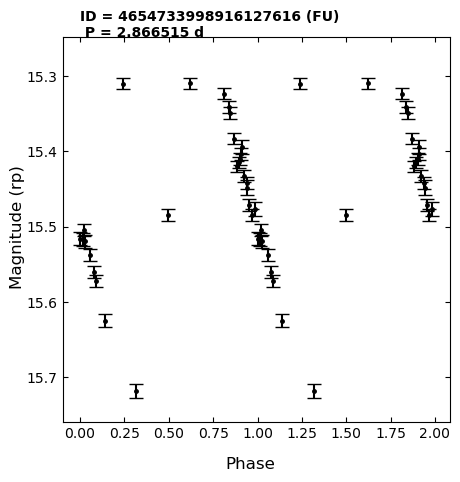

In [66]:
plot(4654733998916127616, 'rp')

# Test

In [58]:
# data = pd.read_csv('data.csv')
# fundamental = data.loc[data.variCepheid_modeBestClassification == 'FUNDAMENTAL'].reset_index(drop = True)

In [59]:
# ID = 4657968208177682432
# path = 'Data/' + str(ID) +'_epochPhotFile.csv'
# cepheid = pd.read_csv(path, skiprows = 3)
# cepheid_cleaned = cepheid.dropna(subset = ['bpObsTime']).reset_index(drop = True)
# bp_mag_med = cepheid_cleaned['bpMag'].median()
# bp_mag_std = cepheid_cleaned['bpMag'].std()
# cepheid_cleaned = cepheid_cleaned[abs(cepheid_cleaned['bpMag'] - bp_mag_med) < 3*bp_mag_std].reset_index(drop = True)
# period = fundamental['variCepheid_pf'][fundamental['variCepheid_sourceId'] == ID].iloc[0]
# phase = ((cepheid_cleaned['bpObsTime'] - cepheid_cleaned['bpObsTime'].iloc[0])/period)%1
# mag = cepheid_cleaned['bpMag']
# mag_err = 2.5/(np.log(10)*cepheid_cleaned['bpFluxOverError'])
# coef, degree, error = fourier_decomposition(phase, mag, mag_err)

# p = np.arange(0,2+0.01,0.01)

# mode = 'FU'
# plt.figure(figsize = (5,6))
# # plt.scatter([phase, phase + 1], [mag, mag], s = 20, color = 'black',label = 'Observations')
# plt.errorbar(phase, y = mag, yerr=mag_err, fmt = '.', color = 'black', capsize=5, markersize=5)
# plt.plot(p, [fourier_series(t,*coef) for t in p],'r--', label = 'Fourier model')
# plt.text(0, min(mag) - 0.01, f'ID = {ID} ({mode})\n P = {np.round(period,6)} d', fontsize=13, fontweight='bold')
# plt.ylim([min(mag) - 1.5*(max(mag) - min(mag))/10, max(mag) + 0.01])
# plt.gca().invert_yaxis()
# plt.xlabel('Phase')
# plt.ylabel('Magnitude')
# plt.tick_params(axis='both', which='major', direction='in', top=True, bottom=True, left=True, right=True)
# plt.tick_params(axis='both', which='minor', direction='in', top=True, bottom=True, left=True, right=True)


In [68]:
data = pd.read_csv('data_LMC.csv')
data = data[(data['variCepheid_peakToPeakG'] < 2.5) & (data['variCepheid_peakToPeakBP'] < 2.5) & 
            (data['variCepheid_peakToPeakRP'] < 2.5) & (data['variCepheid_numCleanEpochsBP'] > 30) &
            (data['variCepheid_numCleanEpochsRP'] > 30) & (data['variCepheid_numCleanEpochsG'] > 30)].reset_index(drop = True)
lightcurve_path = 'data_LMC/'
count = data['variCepheid_modeBestClassification'].value_counts()
count['FIRST_OVERTONE'], count['FUNDAMENTAL']

(1663, 2172)

In [31]:
data = pd.read_csv('cepheids.csv')
lightcurve_path = 'phot_files/'

## Fitting

In [11]:
first_o = data.loc[data.variCepheid_modeBestClassification == 'FIRST_OVERTONE'].reset_index(drop = True)
fundamental = data.loc[data.variCepheid_modeBestClassification == 'FUNDAMENTAL'].reset_index(drop = True)

35
28
27
4657313762426796160 FUNDAMENTAL 3 0.00023398920683136224 25
37
33
33
4658294144531809792 FUNDAMENTAL 3 0.00025159076846670715 30
43
38
36
4654861198661984384 FUNDAMENTAL 3 5.9422186411561264e-05 34
45
39
38
4661687619693652480 FUNDAMENTAL 3 4.463879061491811e-05 35
36
29
29
4651044484590765952 FIRST_OVERTONE 2 0.00012843260295669433 26
42
36
35
4658067164221312896 FIRST_OVERTONE 1 0.001341515178804345 30
41
36
35
4659112490428308736 FIRST_OVERTONE 3 8.839149597920653e-05 31
40
37
36
4652123449106468736 FIRST_OVERTONE 1 0.00013626691978092776 31


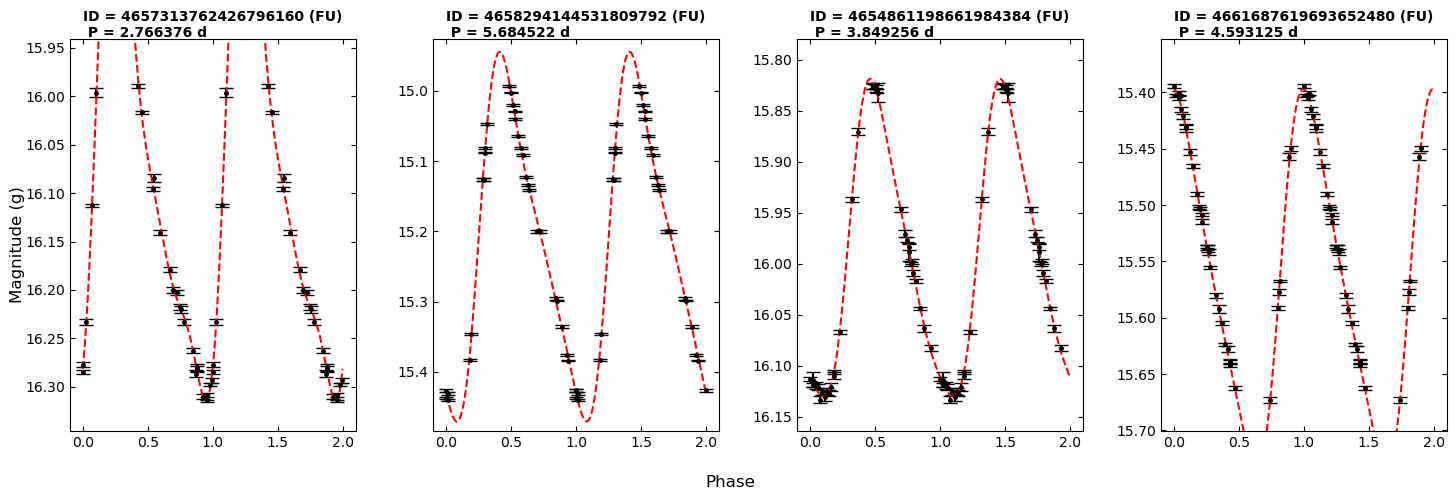

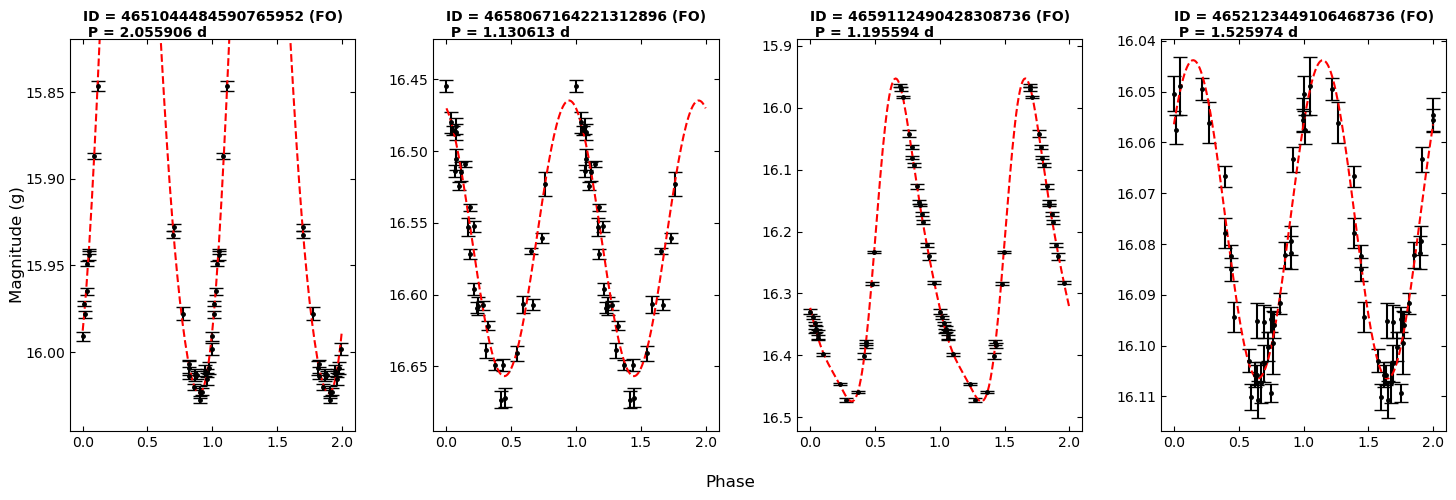

In [19]:
seed = 42
np.random.seed(seed)
ind = fundamental['variCepheid_sourceId'].sample(4, replace=False).tolist()
plot_lightcurve(data, lightcurve_path, ind, 'g')
ind = first_o['variCepheid_sourceId'].sample(4, replace=False).tolist()
plot_lightcurve(data, lightcurve_path, ind, 'g')

## Distance

In [18]:
# mode = 'FUNDAMENTAL'
# w, w_err, P, P_err = run(data, lightcurve_path, n_samples = count[mode], mode = mode)

In [69]:
w_f, w_f_err, P_f, P_f_err, ID_failed_FD = run(data, lightcurve_path, n_samples = count['FUNDAMENTAL'], mode = 'FUNDAMENTAL')
w_o, w_o_err, P_o, P_o_err, ID_failed_FO = run(data, lightcurve_path, n_samples = count['FIRST_OVERTONE'], mode = 'FIRST_OVERTONE')

100%|███████████████████████████████████████| 2172/2172 [45:00<00:00,  1.24s/it]


Total samples: 2172
Samples processed: 2156


100%|███████████████████████████████████████| 1663/1663 [13:36<00:00,  2.04it/s]

Total samples: 1663
Samples processed: 1652


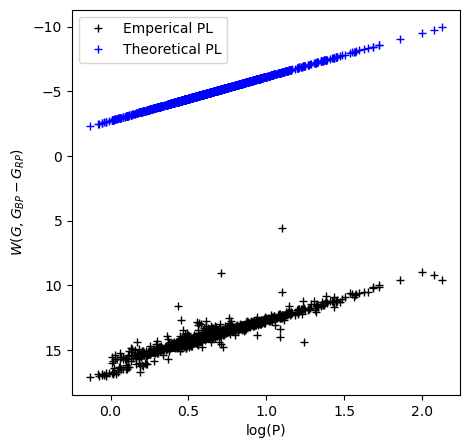

In [70]:
W_f = -2.744 - 3.391*np.log10(P_f)

sigma_logP =  P_f_err/(P_f*np.log(10))
mean_logP = np.log10(P_f) - sigma_logP**2/2

W_f_err = np.sqrt(0.045**2 + (0.052*sigma_logP)**2 + (3.391*sigma_logP)**2 + (0.052*mean_logP)**2)
plt.figure(figsize = (5,5))
plt.plot(np.log10(P_f),w_f, color='black', marker='+', linewidth = 0, label = 'Emperical PL')
plt.plot(np.log10(P_f),W_f,'b+', label = 'Theoretical PL')
plt.gca().invert_yaxis()
plt.xlabel('log(P)')
plt.ylabel(r'$W(G, G_{BP} - G_{RP})$')
plt.legend()

In [71]:
DM_calculator(w_f, w_f_err, W_f, W_f_err)

(48168.08633741485,
 411.4045103541853,
 18.413796963188325,
 0.018546585744070587)

In [72]:
W_o = -3.324 - 3.588*np.log10(P_o)

sigma_logP =  P_o_err/(P_o*np.log(10))
mean_logP = np.log10(P_o) - sigma_logP**2/2

W_o_err = np.sqrt(0.028**2 + (0.056*sigma_logP)**2 + (3.358*sigma_logP)**2 + (0.056*mean_logP)**2)

In [73]:
DM_calculator(w_o, w_o_err, W_o, W_o_err)

(59013.22935867198,
 116.9134895649769,
 18.85474690511133,
 0.0043019915983179054)

In [91]:
fund = pd.DataFrame({'w': w_f, 'w_error': w_f_err, 'W': W_f, 'W_error': W_f_err,'P': P_f, 'P_error': P_f_err,'Type': 'FU'})
w_mean = fund['w'].median()
w_std = fund['w'].std()
fund = fund.assign(w_deviation = abs(fund['w'] - w_mean))
fund = fund[fund['w_deviation'] < 3*w_std]

over = pd.DataFrame({'w': w_o, 'w_error': w_o_err, 'W': W_o, 'W_error': W_o_err,'P': P_o, 'P_error': P_o_err,'Type': 'FO'})
w_mean = over['w'].median()
w_std = over['w'].std()
over = over.assign(w_deviation = abs(over['w'] - w_mean))
over = over[over['w_deviation'] < 3*w_std]


last = pd.concat([fund, over], ignore_index=True)

In [92]:
last

,w,w_error,W,W_error,P,P_error,Type,w_deviation
0,14.355507,0.006530,-4.439089,0.051968,3.161395,0.000045,FU,0.225267
1,14.647493,0.024514,-4.381332,0.051531,3.039810,0.000040,FU,0.517252
2,14.229634,0.012974,-4.441631,0.051988,3.166857,0.000095,FU,0.099393
3,14.602105,0.013468,-4.144394,0.049861,2.588057,0.000079,FU,0.471864
4,14.210879,0.002441,-4.579876,0.053081,3.478536,0.000015,FU,0.080639
...,...,...,...,...,...,...,...,...
3745,14.608281,0.006551,-4.338242,0.032165,1.917239,0.000031,FO,0.114162
3746,14.684423,0.005275,-4.295738,0.031844,1.865649,0.000072,FO,0.190303
3747,14.396682,0.005710,-4.420487,0.032816,2.021149,0.000014,FO,0.097437
3748,16.189359,0.055584,-2.788308,0.029222,0.709086,0.000005,FO,1.695239


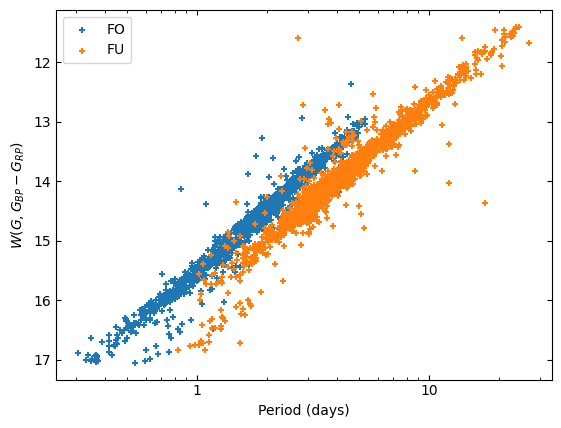

In [94]:
import matplotlib.ticker as ticker

for data_type, group in last.groupby('Type'):
    plt.scatter(group['P'], group['w'], marker = '+', s = 20, label=data_type)

plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.f'))
plt.gca().invert_yaxis()
plt.xlabel('Period (days)')
plt.ylabel(r'$W(G, G_{BP} - G_{RP})$')
plt.tick_params(axis='both', which='major', direction='in', top=True, bottom=True, left=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', top=True, bottom=True, left=True, right=True)

In [104]:
def distance_calculator(a,a_err,b,b_err,w,w_err,P,P_err, plot = False):
    model = lambda P: a + b*np.log10(P)

    W = model(P)
    sigma_logP =  P_err/(P*np.log(10))
    mean_logP = np.log10(P) - sigma_logP**2/2
    
    W_err = np.sqrt(a_err**2 + (b_err*sigma_logP)**2 + (b*sigma_logP)**2 + (b_err*mean_logP)**2)

    if plot:
        plt.figure(figsize = (5,5))
        plt.plot(np.log10(P),w, color='black', marker='+', linewidth = 0, label = 'Emperical PL')
        plt.plot(np.log10(P),W,'b+', label = 'Theoretical PL')
        plt.gca().invert_yaxis()
        plt.xlabel('log(P)')
        plt.ylabel(r'$W(G, G_{BP} - G_{RP})$')
        plt.legend()

    d, d_err, DM, DM_err = DM_calculator(w, w_err, W, W_err)

    print('Distance: %.3f +/- %.3f kpc\nDistance modulus: %.3f +/- %.3f'%(d/1000,d_err/1000,DM,DM_err))

Distance: 55.538 +/- 0.137 kpc
Distance modulus: 18.723 +/- 0.005


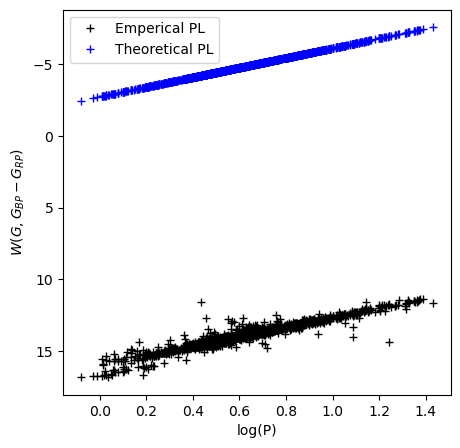

In [105]:
w_f = last['w'].loc[last.Type == 'FU']
w_f_err = last['w_error'].loc[last.Type == 'FU']
P_f = last['P'].loc[last.Type == 'FU']
P_f_err = last['P_error'].loc[last.Type == 'FU']
distance_calculator(-2.744, 0.045, -3.391, 0.052, w_f, w_f_err, P_f, P_f_err, plot = True)

Text(0, 0.5, 'DEC')

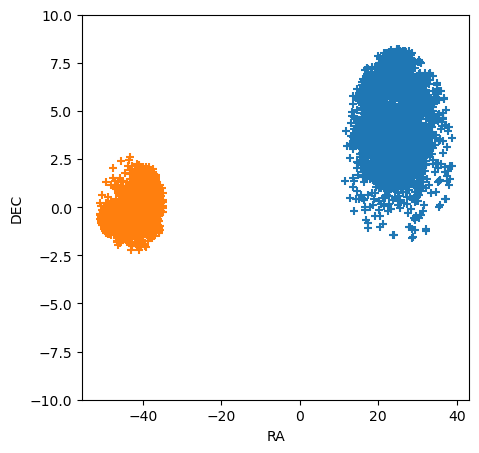

In [41]:
from astropy.coordinates import SkyCoord
from astropy import units as u
sample = data.sample(count.sum(), replace=False)

data_SMC = pd.read_csv('data_SMC.csv')

ra_center = 56
dec_center = -73

ra = np.array(
    sample['gaiaSource_ra'])
dec = np.array(sample['gaiaSource_decl'])

coords_LMC = SkyCoord(ra=ra, dec=dec, unit = 'degree', frame='icrs')
coords_SMC = SkyCoord(ra=data_SMC['gaiaSource_ra'], dec=data_SMC['gaiaSource_decl'], unit = 'degree', frame='icrs')

center_coords = SkyCoord(ra=ra_center, dec=dec_center, unit = 'degree', frame='icrs', equinox = 'J2000')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111) 

ra_offset = (coords.ra - center_coords.ra)
dec_offset = (coords.dec - center_coords.dec)

ra_SMC = (coords_SMC.ra - center_coords.ra)
dec_SMC = (coords_SMC.dec - center_coords.dec)


ax.scatter(ra_offset, dec_offset, marker ='+')
ax.scatter(ra_SMC, dec_SMC, marker ='+')

ax.set_ylim([-10,10])


ax.set_xlabel('RA')
ax.set_ylabel('DEC')


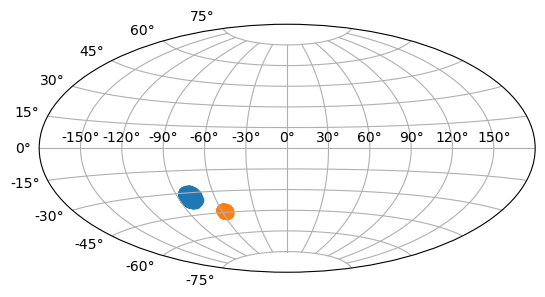

In [54]:
gal = coords.galactic
gal_SMC = coords_SMC.galactic

plt.figure()
plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian)
plt.scatter(gal_SMC.l.wrap_at('180d').radian, gal_SMC.b.radian)